# Training Neural Networks with Noisy Labels

Neural networks, especially deep neural networks with many parameters, require a large amount of training data. This has led to the development of sophisticated data augmentation methods as well as entire industries dedicated to data annotation. The validation of these annotation labels is a common problem whenever such a large amount of data is involved as incorrect, or noisy, labels can lead to incorrectly trained machine learning algorithms that do not properly identify patterns within the data.

## Imports

In [2]:
%matplotlib inline
import h5py
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import SVG
import keras.utils
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten

## The Data
To showcase the effects of noisy labels, I will use the [MNIST handwritten digit dataset](http://yann.lecun.com/exdb/mnist/). I have previously downloaded and pre-processed the data and stored it in an HDF5 file.

In [3]:
with h5py.File("MNIST.h5", "r") as h5handle:
    images = h5handle["images"][()]
    labels = h5handle["labels"][()].astype(np.str)

The images are stored as a 4D array (Tensorflow format: batch size, width, height, number of channels) and the labels are a simple 1D array.

In [4]:
print("Images array shape: {}".format(images.shape))
print("Labels array shape: {}".format(labels.shape))

Images array shape: (70000, 28, 28, 1)
Labels array shape: (70000,)


A look at some of the digits shows us the expected output.

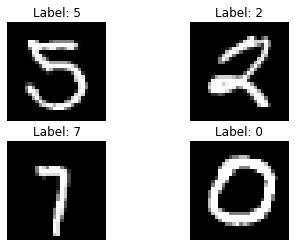

In [5]:
fig, ax = plt.subplots(2, 2);
ax[0, 0].imshow(images[284, ..., 0], cmap="gray");
ax[0, 0].set_title("Label: " + labels[284]);
ax[0, 0].axis("off");
ax[0, 1].imshow(images[1129, ..., 0], cmap="gray");
ax[0, 1].set_title("Label: " + labels[1129]);
ax[0, 1].axis("off");
ax[1, 0].imshow(images[9470, ..., 0], cmap="gray");
ax[1, 0].set_title("Label: " + labels[9470]);
ax[1, 0].axis("off");
ax[1, 1].imshow(images[30044, ..., 0], cmap="gray");
ax[1, 1].set_title("Label: " + labels[30044]);
ax[1, 1].axis("off");
plt.show()

## The Model
We'll be using a simple convolutional network for this task. MNIST is an extremely easy dataset to classify and doesn't require a particularly sophisticated model.

In [65]:
def get_model(img_shape, nclasses):
    """
    Build convolutional network
    :param img_shape:
    :param nclasses:
    :return:
    """
    inputs = Input(shape=img_shape, name="Input")
    conv1 = Conv2D(
        filters=32, kernel_size=(3, 3),
        activation="relu", padding="valid",
        strides=(1, 1), name="Conv1")(inputs)
    conv2 = Conv2D(
        filters=32, kernel_size=(3, 3),
        activation="relu", padding="valid",
        strides=(1, 1), name="Conv2")(conv1)
    maxpool1 = MaxPool2D(
        pool_size=(3, 3), strides=(2, 2), 
        padding="valid", name="MaxPool1")(conv2)

    conv3 = Conv2D(
        filters=64, kernel_size=(3, 3),
        activation="relu", padding="valid",
        strides=(1, 1), name="Conv3")(maxpool1)
    conv4 = Conv2D(
        filters=64, kernel_size=(3, 3),
        activation="relu", padding="valid",
        strides=(1, 1), name="Conv4")(conv3)
    maxpool2 = MaxPool2D(
        pool_size=(3, 3), strides=(2, 2), 
        padding="valid", name="MaxPool2")(conv4)

    flattened = Flatten(name="Reshape")(maxpool2)

    outputs = Dense(name="Dense", units=nclasses, activation="sigmoid")(flattened)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss="categorical_crossentropy", optimizer="Adam")
    
    return model

In [66]:
model = get_model(
    img_shape=images.shape[1:4], 
    nclasses=len(np.unique(labels)))

In [87]:
def print_model(model):
    desc = "Name      | Output Shape        | Kernel / Pool Shape\n"
    desc += "----------|---------------------|--------------------\n"
    for layer in model.layers:
        desc += "{:<10}|".format(layer.name)
        desc += " {:<20}|".format(str(layer.output_shape))
        if hasattr(layer, "kernel"):
            desc += " {:<20}".format(str(layer.kernel.shape.as_list()))
        if hasattr(layer, "pool_size"):
            desc += " {:<20}".format(str(layer.pool_size))
        desc += "\n"
    print(desc)
    
print_model(model)

Name      | Output Shape        | Kernel / Pool Shape
----------|---------------------|--------------------
Input     | (None, 28, 28, 1)   |
Conv1     | (None, 26, 26, 32)  | [3, 3, 1, 32]       
Conv2     | (None, 24, 24, 32)  | [3, 3, 32, 32]      
MaxPool1  | (None, 11, 11, 32)  | (3, 3)              
Conv3     | (None, 9, 9, 64)    | [3, 3, 32, 64]      
Conv4     | (None, 7, 7, 64)    | [3, 3, 64, 64]      
MaxPool2  | (None, 3, 3, 64)    | (3, 3)              
Reshape   | (None, 576)         |
Dense     | (None, 10)          | [576, 10]           



## Scrambling the labels
Next, we want to define a function that scrambles the labels. It's important that this function allows us to control the fraction of labels that are guaranteed to be correct. That means labels selected for scrambling may not get their original label assigned to them.

In [ ]:
def scramble_labels(labels, percentage, possible_values=None):
    """
    Takes a label vector and randomly scrambles a fraction of the labels.

    The scrambling ensures that none of the altered labels will have their
    original value, i.e. the scrambling percentage is guaranteed.

    By default, the function assumes that 'labels' contains all possible 
    label values. Should this not be the case, 'possible_values' can be used
    to pass a list of all possible labels.

    :param labels: Numpy array (num_labels,)
    :param percentage: Integer
    :param possible_values: Numpy array (num_unique_labels,)
    :return:
    """
    if percentage > 1:
        print("'scramble_freq' truncated to 1.0")
        percentage = 1.0

    if percentage == 0:
        return labels

    labels = labels.flatten()

    labels_to_scramble = np.random.choice(
        a=range(len(labels)),
        size=int(len(labels) * percentage),
        replace=False)

    # Define possible values for each entry
    if possible_values is None:
        possible_values = np.unique(labels)
    
    if not np.all(np.isin(np.unique(labels), possible_values)):
        raise ValueError(
            "'labels' contains values not found in 'possible_values'")
    
    possible_values = np.repeat(
        a=np.expand_dims(possible_values, 0),
        repeats=labels_to_scramble.shape[0],
        axis=0)
    forbidden_values = np.repeat(
        a=np.expand_dims(labels[labels_to_scramble], 1),
        repeats=len(np.unique(labels)), axis=1)

    sel = possible_values != forbidden_values
    new_possible_values = np.reshape(
        a=possible_values[sel],
        newshape=(possible_values.shape[0], possible_values.shape[1]-1))

    new_values = []
    for vals in new_possible_values:
        new_values.append(np.random.choice(vals))
    new_values = np.array(new_values)
    labels[labels_to_scramble] = new_values

    return labels

We can test this function with a dummy example:

In [ ]:
dummy_labels = np.arange(10).astype(str)
print("Original labels: {}".format(dummy_labels))
print("10% scrambling:  {}".format(scramble_labels(dummy_labels, 0.1)))
print("50% scrambling:  {}".format(scramble_labels(dummy_labels, 0.5)))
print("100% scrambling: {}".format(scramble_labels(dummy_labels, 1)))

Since we'

In [ ]:
print(dummy_labels)
keras.utils.to_categorical(dummy_labels)

In [ ]:
scrambled_labels = scramble_labels(dummy_labels, 0.5)
print(scrambled_labels)
keras.utils.to_categorical(scrambled_labels)